Jared Madamba
DA320

Project Direction from Professor Theodore Spence:
https://github.com/tspence/data-analysis-class-resources/blob/main/jupyter/Topic%20Classification%20Example.ipynb

In [2]:
# Imports and Connection Setup
import torch
import pandas as pd
import json
import pymongo
import certifi
import re
from matplotlib import pyplot

# Fetch MongoDB Credentials (generic, unprotected dummy key)
with open('C:\\Users\\JaredM\\Downloads\\secrets.json') as f:
    data = json.load(f)

    connection_string = data['mongodb']

# Verify connection string was fetched
print(f"My secret key is {len(connection_string)} characters in length.")

My secret key is 59 characters in length.


In [46]:
# Connect to Database
client = pymongo.MongoClient(connection_string, tlsCAFile=certifi.where())

# Fetch Database
movie_database = client['Movies']

# Fetch Collections In Database
collections = movie_database.list_collection_names()

# Verify collections found
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {collections}")

Using MongoDB version 6.0.6.
This database has the collections ['metacritic', 'imdb', 'mc_pipeline', 'imdb-pipeline', 'imdb_pipeline']


In [85]:
# Fetch data from IMDB aggregator Pipeline for the year 2000
imdb = pd.DataFrame(movie_database.imdb_pipeline.find({"release_year": 2002}))

# Fetch data from metacritic aggregator Pipeline for the year 2000
metacritic = pd.DataFrame(movie_database.mc_pipeline.find({"release_year": 2002}))


# imdb.head()

In [107]:
# Merging imdb and metacritic data sets by Movie Title
unified_view = pd.merge(imdb, metacritic, how="inner", on="title")
unified_view.head()

,_id_x,title,runtime,user_rating,votes,budget,opening_weekend,gross_sales,release_date_x,genre,...,producer,company,mpaa_rating,age_rating,release_year_x,_id_y,release_date_y,description,metascore,release_year_y
0,64582e7d3f9dce2077397292,Cherish,99,6,2823,1500000,36618.0,NaN,2002-01-14,"[Comedy, Drama, Mystery, Thriller]",...,"[Jeff Boortz, Debbie Brubaker, Mark Burton, Jo...","[3 Ring Circus Films, Concrete Pictures, Outpo...",[R],R,2002,64582ebb3f9dce207739cafb,2002-06-07,A fantasy-prone young woman confronts a life-a...,51,2002
1,64582e7d3f9dce207739731a,Evelyn,94,7,6708,10000000,65344.0,NaN,2002-09-09,[Drama],...,"[Kevan Barker, Simon Bosanquet, Pierce Brosnan...","[First Look International, Cinerenta Medienbet...",[PG],PG,2002,64582eba3f9dce207739cae5,2002-12-13,This story of an Irish man's fight to keep his...,55,2002
2,64582e7d3f9dce20773974fe,Catch Me If You Can,141,8,945195,52000000,30082000.0,352114312.0,2002-12-16,"[Biography, Crime, Drama]",...,"[Barry Kemp, Daniel Lupi, Laurie MacDonald, Se...","[Dreamworks Pictures, Kemp Company, Splendid P...",[PG-13],PG-13,2002,64582eba3f9dce207739ca33,2002-12-25,Frank W. Abagnale (DiCaprio) worked as a docto...,75,2002
3,64582e7d3f9dce207739752a,Star Wars: Episode II - Attack of the Clones,142,6,694527,115000000,80027814.0,649398328.0,2002-05-12,"[Action, Adventure, Fantasy, Sci-Fi]",...,"[George Lucas, Rick McCallum, Lorne Orleans]","[Lucasfilm, Recce & Production Services, Mesti...","[TV-PG, (DLV, TV rating)]",TV-PG,2002,64582eba3f9dce207739caea,2002-05-16,"Ten years after the invasion of Naboo, the gal...",54,2002
4,64582e7d3f9dce207739752b,Scooby-Doo,89,5,110796,84000000,54155312.0,99000000.0,2002-06-08,"[Adventure, Comedy, Family, Fantasy, Mystery]",...,"[Joseph Barbera, Sheryl Benko, Robert Engelman...","[Warner Bros., Mosaic, Atlas Entertainment]","[TV-PG, (DLV, Cartoon Network)]",TV-PG,2002,64582ebb3f9dce207739cb62,2002-06-14,Scooby Doo and the Mystery Inc. gang take thei...,35,2002


In [72]:
from transformers import pipeline

# introduce classifier to notebook
classifier = pipeline("fill-mask", model="distilbert-base-uncased")
# test
classifier("There so many [MASK] in America!")

[{'score': 0.021699054166674614,
  'token': 3182,
  'token_str': 'places',
  'sequence': 'there so many places in america!'},
 {'score': 0.021411102265119553,
  'token': 2308,
  'token_str': 'women',
  'sequence': 'there so many women in america!'},
 {'score': 0.01292557641863823,
  'token': 15618,
  'token_str': 'castles',
  'sequence': 'there so many castles in america!'},
 {'score': 0.011385365389287472,
  'token': 6667,
  'token_str': 'colleges',
  'sequence': 'there so many colleges in america!'},
 {'score': 0.011088644154369831,
  'token': 3655,
  'token_str': 'cities',
  'sequence': 'there so many cities in america!'}]

In [108]:
# Classifier Prompt
prompt_column = unified_view.apply(lambda row : f"The movie is called {row['title']}. The genre of this movie is [MASK].", axis = 1)
unified_view.insert(0, "prompt", prompt_column)

# Execute on entirety of merged dataset
category_column = unified_view.apply(lambda row: classifier(row['prompt'])[0]['token_str'], axis = 1)
unified_view.insert(0, "category", category_column)

# unified_view.head()

,category,prompt,_id_x,title,runtime,user_rating,votes,budget,opening_weekend,gross_sales,...,producer,company,mpaa_rating,age_rating,release_year_x,_id_y,release_date_y,description,metascore,release_year_y
0,romance,The movie is called Cherish. The genre of this...,64582e7d3f9dce2077397292,Cherish,99,6,2823,1500000,36618.0,NaN,...,"[Jeff Boortz, Debbie Brubaker, Mark Burton, Jo...","[3 Ring Circus Films, Concrete Pictures, Outpo...",[R],R,2002,64582ebb3f9dce207739cafb,2002-06-07,A fantasy-prone young woman confronts a life-a...,51,2002
1,romance,The movie is called Evelyn. The genre of this ...,64582e7d3f9dce207739731a,Evelyn,94,7,6708,10000000,65344.0,NaN,...,"[Kevan Barker, Simon Bosanquet, Pierce Brosnan...","[First Look International, Cinerenta Medienbet...",[PG],PG,2002,64582eba3f9dce207739cae5,2002-12-13,This story of an Irish man's fight to keep his...,55,2002
2,romance,The movie is called Catch Me If You Can. The g...,64582e7d3f9dce20773974fe,Catch Me If You Can,141,8,945195,52000000,30082000.0,352114312.0,...,"[Barry Kemp, Daniel Lupi, Laurie MacDonald, Se...","[Dreamworks Pictures, Kemp Company, Splendid P...",[PG-13],PG-13,2002,64582eba3f9dce207739ca33,2002-12-25,Frank W. Abagnale (DiCaprio) worked as a docto...,75,2002
3,fantasy,The movie is called Star Wars: Episode II - At...,64582e7d3f9dce207739752a,Star Wars: Episode II - Attack of the Clones,142,6,694527,115000000,80027814.0,649398328.0,...,"[George Lucas, Rick McCallum, Lorne Orleans]","[Lucasfilm, Recce & Production Services, Mesti...","[TV-PG, (DLV, TV rating)]",TV-PG,2002,64582eba3f9dce207739caea,2002-05-16,"Ten years after the invasion of Naboo, the gal...",54,2002
4,comedy,The movie is called Scooby-Doo. The genre of t...,64582e7d3f9dce207739752b,Scooby-Doo,89,5,110796,84000000,54155312.0,99000000.0,...,"[Joseph Barbera, Sheryl Benko, Robert Engelman...","[Warner Bros., Mosaic, Atlas Entertainment]","[TV-PG, (DLV, Cartoon Network)]",TV-PG,2002,64582ebb3f9dce207739cb62,2002-06-14,Scooby Doo and the Mystery Inc. gang take thei...,35,2002


In [50]:
# Formats large numbers of currency into shorthand
# Derived from Professor Theodore Spence: https://github.com/tspence/data-analysis-class-resources/blob/main/jupyter/Basics%20of%20Plotting.ipynb
def format_currency(amount, _):
    if amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"

<function matplotlib.pyplot.show(close=None, block=None)>

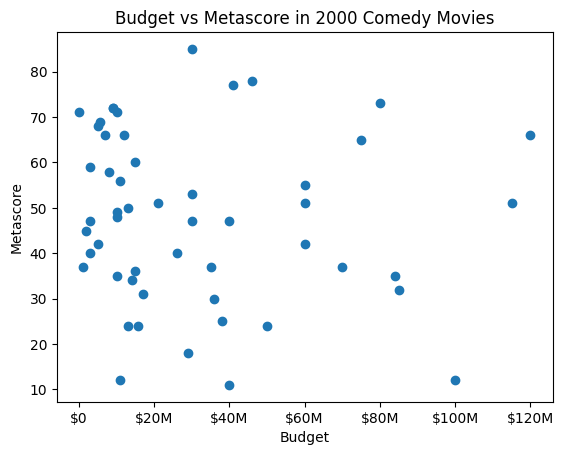

In [118]:
# Plot Budget vs Score for Comedy Movies

comMovies = unified_view.query("category == 'comedy'")

pyplot.scatter(comMovies['budget'], comMovies['metascore'])
pyplot.title("Budget vs Metascore in 2000 Comedy Movies")
pyplot.xlabel("Budget")
pyplot.ylabel("Metascore")
pyplot.gca().xaxis.set_major_formatter(format_currency)
pyplot.show


<function matplotlib.pyplot.show(close=None, block=None)>

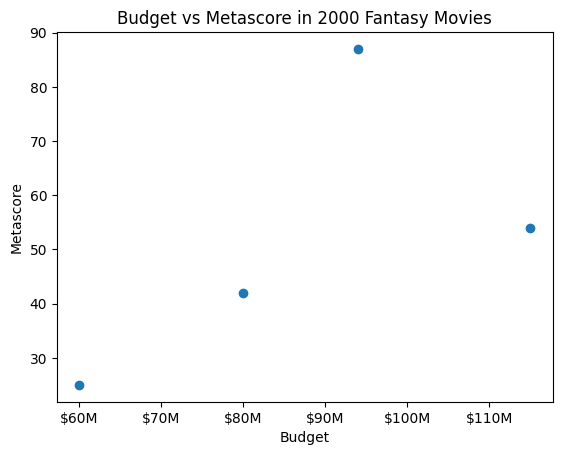

In [119]:
# Plot Budget vs Score for Fantasy Movies

fanMovies = unified_view.query("category == 'fantasy'")

pyplot.scatter(fanMovies['budget'], fanMovies['metascore'])
pyplot.title("Budget vs Metascore in 2000 Fantasy Movies")
pyplot.xlabel("Budget")
pyplot.ylabel("Metascore")
pyplot.gca().xaxis.set_major_formatter(format_currency)
pyplot.show

Not a very good year for Fantasy enjoyers I guess, but there was at least one very good film! 
For comedy enjoyers, the lower-budget comedy movies (or ones that Dillbert thought were comedy movies) competed well with the higher-budget movies within the genre that year, despite the saturation of comedy films.

As a takeaway, messing around with the prompt engineering only to constantly get irrelevant or 'unknown' answers really highlights the need for AI to be assisted by humans. While this is a lesser example, we are needed to recognize bad outputs and attempt to rectify it. Had I not checked the outputs, the plots I made would be empty or completely nonsensical.
